In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.missing_values_handling import DummyMissingValuesHandler
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from observability.mlflow_integration import log_experiment

from config.experiments.cur_experiment import config

c:\Users\ikurnosau\Projects\QuantitativeTrading\intraday-portfolio-management\data\processed\normalization.py:100: SyntaxWarning: invalid escape sequence '\h'
  """Rolling-window Min-Max scaler.
C:\Users\ikurnosau\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [14]:
rng = pd.date_range(start="2024-06-01",
                    end="2025-06-01",
                    freq="H",
                    tz="UTC",          # optional – adds timezone info
                    inclusive="left")  # include start, exclude end

df = pd.DataFrame({"date": rng})

from data.processed.data_processing_utils import filter_by_regular_hours
df = filter_by_regular_hours(df, 'date')
df['date'] = pd.to_datetime(df['date'])
df

C:\Users\ikurnosau\AppData\Local\Temp\ipykernel_5256\432478886.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(start="2024-06-01",


,date
0,2024-06-03 14:00:00+00:00
1,2024-06-03 15:00:00+00:00
2,2024-06-03 16:00:00+00:00
3,2024-06-03 17:00:00+00:00
4,2024-06-03 18:00:00+00:00
...,...
1815,2025-05-30 16:00:00+00:00
1816,2025-05-30 17:00:00+00:00
1817,2025-05-30 18:00:00+00:00
1818,2025-05-30 19:00:00+00:00


In [38]:
symbol = 'MU'
from datetime import datetime, timedelta

retriever = AlpacaMarketsRetriever()
quotes = []
for start_date in df['date'][:100]:
    end_date = start_date + timedelta(hours=1)
    retrieval_result = retriever.quotes(symbol, start_date, end_date, limit=1)
    if symbol in retrieval_result:
        quotes.append(retrieval_result[symbol][0])

spreads = [(quote.ask_price - quote.bid_price) / quote.ask_price for quote in quotes]

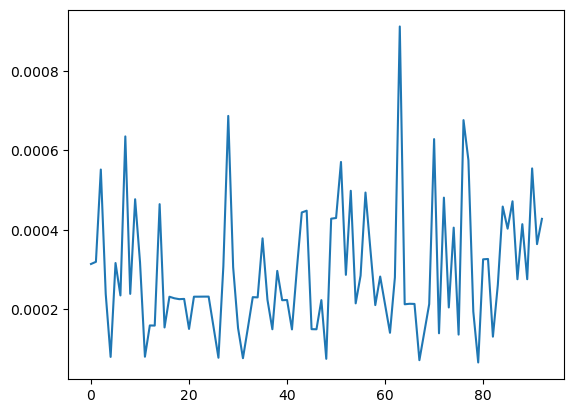

In [39]:
import matplotlib.pyplot as plt
plt.plot(spreads)

In [ ]:

retrieval_result = retriever.quotes(
    symbol_or_symbols='DELL', 
    start=datetime(2024, 6, 3, 15), 
    end=datetime(2024, 6, 3, 16), limit=1)

In [10]:
retrieval_result

{'DELL': [{   'ask_exchange': 'Z',
      'ask_price': 130.36,
      'ask_size': 5.0,
      'bid_exchange': 'T',
      'bid_price': 130.22,
      'bid_size': 3.0,
      'conditions': ['R'],
      'symbol': 'DELL',
      'tape': 'A',
      'timestamp': datetime.datetime(2024, 6, 3, 15, 0, 0, 135647, tzinfo=TzInfo(UTC))}]}

In [12]:
retriever = AlpacaMarketsRetriever()

retrieval_result = retriever.bars(
    symbol_or_symbols='TSLA', 
    start=config.data_config.start, 
    end=config.data_config.end)

In [13]:
dataset_creator = DatasetCreator(
    features=config.data_config.features,
    target=config.data_config.target,
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    train_set_last_date=config.data_config.train_set_last_date, 
    in_seq_len=config.data_config.in_seq_len,
    multi_asset_prediction=config.data_config.multi_asset_prediction,
)
features = dataset_creator.create_dataset_numpy(retrieval_result)

2025-06-21 14:56:05,731 - INFO - Processing TSLA...
2025-06-21 14:56:05,861 - INFO - Filtered by regular hours!
2025-06-21 14:56:06,007 - INFO - Missing values are handled!
2025-06-21 14:56:06,011 - INFO - Total ohlvc rows: 39882. Rows with nulls: 0
2025-06-21 14:56:07,464 - INFO - Features calculated!
2025-06-21 14:56:07,521 - INFO - Features normalized!
2025-06-21 14:56:07,552 - INFO - Target calculated!


In [14]:
features['TSLA']

,date,open,high,low,close,volume,return,OBV,RSI6,RSI12,...,ATR_28,FRL_0,FRL_1,FRL_2,FRL_3,FRL_4,RSI_28,Oscillator_K,Oscillator_D,target
0,2025-01-02 13:30:00+00:00,0.864016,0.862829,0.863156,0.863593,0.001330,NaN,0.347404,NaN,NaN,...,0.099815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2025-01-02 13:31:00+00:00,0.863703,0.863648,0.865185,0.863593,0.000780,0.528465,0.347404,NaN,NaN,...,0.095548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2025-01-02 13:32:00+00:00,0.864596,0.863724,0.864252,0.864754,0.001198,0.533221,0.347510,1.000000,1.000000,...,0.095114,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.0
3,2025-01-02 13:33:00+00:00,0.864819,0.863634,0.864475,0.862700,0.000770,0.520055,0.347442,0.361111,0.361111,...,0.093774,NaN,NaN,NaN,NaN,NaN,0.314424,NaN,NaN,1.0
4,2025-01-02 13:34:00+00:00,0.863257,0.862516,0.864519,0.863369,0.000635,0.531210,0.347498,0.471264,0.471264,...,0.088472,NaN,NaN,NaN,NaN,NaN,0.432627,NaN,NaN,0.0
5,2025-01-02 13:35:00+00:00,0.863525,0.862516,0.861364,0.860737,0.002294,0.517678,0.347296,0.280899,0.280899,...,0.094452,NaN,NaN,NaN,NaN,NaN,0.228351,NaN,NaN,1.0
6,2025-01-02 13:36:00+00:00,0.861026,0.860235,0.861127,0.859886,0.001011,0.524976,0.347207,0.248485,0.248485,...,0.092899,NaN,NaN,NaN,NaN,NaN,0.193568,NaN,NaN,2.0
7,2025-01-02 13:37:00+00:00,0.860178,0.861017,0.861853,0.861485,0.000766,0.535029,0.347274,0.382501,0.382501,...,0.092253,NaN,NaN,NaN,NaN,NaN,0.337377,NaN,NaN,1.0
8,2025-01-02 13:38:00+00:00,0.862364,0.861219,0.863186,0.862298,0.001134,0.531796,0.347374,0.357513,0.433790,...,0.087056,NaN,NaN,NaN,NaN,NaN,0.392414,NaN,NaN,1.0
9,2025-01-02 13:39:00+00:00,0.862409,0.861219,0.863186,0.862208,0.000793,0.528099,0.347304,0.463087,0.429864,...,0.082217,0.863712,0.863191,0.862768,0.862343,0.861814,0.388202,NaN,NaN,0.0


In [10]:
aapl = features['AAPL']
aapl.to_csv('aapl.csv')

In [11]:
msft = features['MSFT']
msft.to_csv('msft.csv')

In [ ]:
retriever = AlpacaMarketsRetriever()

retrieval_result = retriever.bars(
    symbol_or_symbols=con, 
    start=datetime(2025, 6, 6), 
    end=datetime(2025, 6, 10))